In [1]:
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt
import seaborn as sns

from helper_functions import *
metadata = pd.read_csv("metadata.csv")
metadata_cfdna = metadata[metadata["Sample type"].isin(["cfDNA", "Control"])]
import warnings
warnings.filterwarnings("ignore")
import random


topK = 500
atlas_sample_types = "Tissue,WBC"

from tqdm import tqdm

In [2]:
##### PATHS AND CONFIGURATIONS
datadir = "./datadir"
outputdir = "./outputdir_02102023"

path_to_03_output = os.path.join(outputdir, "03_output_noFDR")
path_to_04_output = os.path.join(outputdir, "04_output_noFDR", "top{}_{}".format(topK, atlas_sample_types.replace(",", "_and_")))
path_to_05_output = os.path.join(outputdir, "05_output_noFDR", "top{}_{}".format(topK, atlas_sample_types.replace(",", "_and_")))
path_to_06_output = os.path.join(outputdir, "06_output_noFDR", "top{}_{}".format(topK, atlas_sample_types.replace(",", "_and_")))
path_to_07_output = os.path.join(outputdir, "07_output_noFDR", "top{}_{}".format(topK, atlas_sample_types.replace(",", "_and_")))
path_to_08_output = os.path.join(outputdir, "08_output_noFDR", "top{}_{}".format(topK, atlas_sample_types.replace(",", "_and_")))

path_to_00_output = os.path.join(outputdir, "00_output_noFDR", "top{}_{}".format(topK, atlas_sample_types.replace(",", "_and_")))
os.system("mkdir -p {}".format(path_to_00_output))
##### atlas
atlas = pd.read_csv(os.path.join(path_to_03_output, "top{}_atlas_{}.final.csv".format(topK, atlas_sample_types)), index_col =[0])
        
atlas = atlas[[item for item in atlas.columns if "_y" not in item ]]
atlas.columns = [item.replace("_x", "") for item in atlas.columns]

avg_atlas = atlas.set_index("sample").fillna(0).groupby("label").mean()
avg_atlas = avg_atlas.loc[atlas_labels[atlas_sample_types]]
atlas_regions = [item for item in atlas.columns if item not in ["sample", "label"]]

dfcfdna = pd.read_csv(os.path.join(path_to_04_output, "top{}_atlas_{}.all_cfDNA_betadf.csv".format(topK, atlas_sample_types.replace(",", "_and_"))), index_col = [0])
dfcontrol = pd.read_csv(os.path.join(path_to_04_output, "top{}_atlas_{}.all_Control_betadf.csv".format(topK, atlas_sample_types.replace(",", "_and_"))), index_col = [0])

deconvo_res_cfdna = deconvo(dfcfdna, avg_atlas, atlas_sample_types)
deconvo_res_cfdna = deconvo_res_cfdna.set_index("TOO").T
deconvo_res_cfdna = deconvo_res_cfdna.reset_index()
deconvo_res_cfdna.columns = ["Sample" if item == "index" else item for item in deconvo_res_cfdna.columns]


<Axes: ylabel='label'>

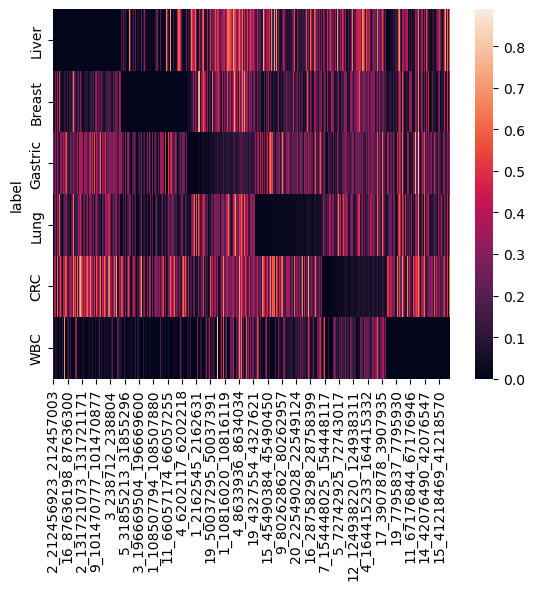

In [3]:
sns.heatmap(avg_atlas)

In [4]:
metadata[metadata["filename"].str.contains("L12008I")]

,filename,Label,Sample type,pair
89,1-L12008I1ME131W_M518-M718,Lung,cfDNA,NaN
90,1-L12008I2ME131W_M519-M719,Lung,cfDNA,NaN
91,1-L12008I3ME131W_M552-M752,Lung,cfDNA,NaN
92,1-L12008I4ME131W_M553-M753,Lung,cfDNA,NaN


In [5]:
path_to_data_rplot = "/datassd/hieunguyen/ECD/tumor_atlas_official/data_for_Rplot"

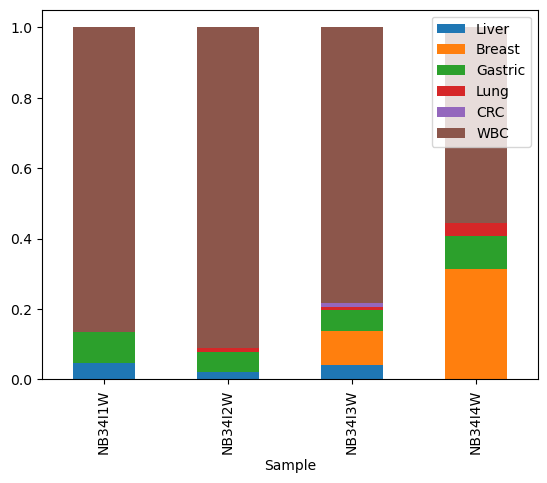

In [6]:
##### DECONVOLUTION OF THE REAL SAMPLES
deconvo_res_cfdna[deconvo_res_cfdna["Sample"].str.contains("NB34I")].set_index("Sample").plot(kind = "bar", stacked = True)
deconvo_res_cfdna[deconvo_res_cfdna["Sample"].str.contains("NB34I")].to_csv(
    os.path.join(path_to_data_rplot, "Figure2_NB34I_GS_atlas.csv"))

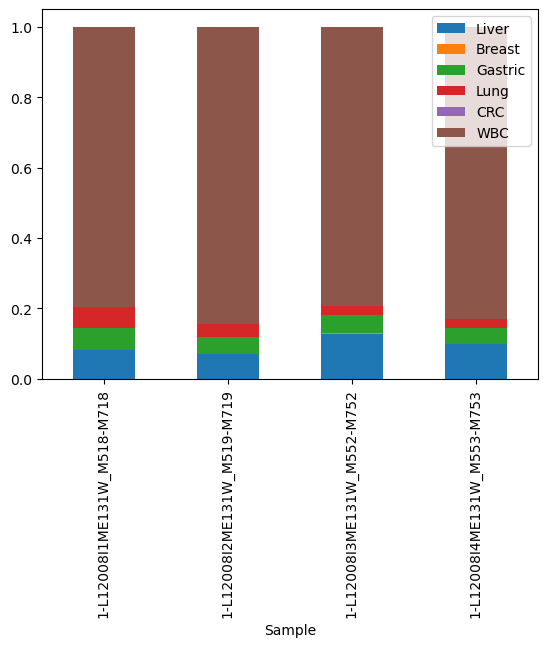

In [7]:
##### DECONVOLUTION OF THE REAL SAMPLES
deconvo_res_cfdna[deconvo_res_cfdna["Sample"].str.contains("L12008I")].set_index("Sample").plot(kind = "bar", stacked = True)
deconvo_res_cfdna[deconvo_res_cfdna["Sample"].str.contains("L12008I")].to_csv(os.path.join(path_to_data_rplot, "Figure2_L12008I_GS_atlas.csv"))

In [8]:
##### DECONVOLUTION OF THE IN SILICO SAMPLES
all_spike_in_results = [item for item in pathlib.Path(os.path.join(path_to_08_output, "tmp")).glob("*")]

resdf = pd.DataFrame()
for file in all_spike_in_results:
    tmpdf= pd.read_csv(file, index_col = [0])
    resdf = pd.concat([resdf, tmpdf], axis = 0)
resdf = resdf.reset_index()
resdf.columns = ["Sample"] + list(resdf.columns)[1:]

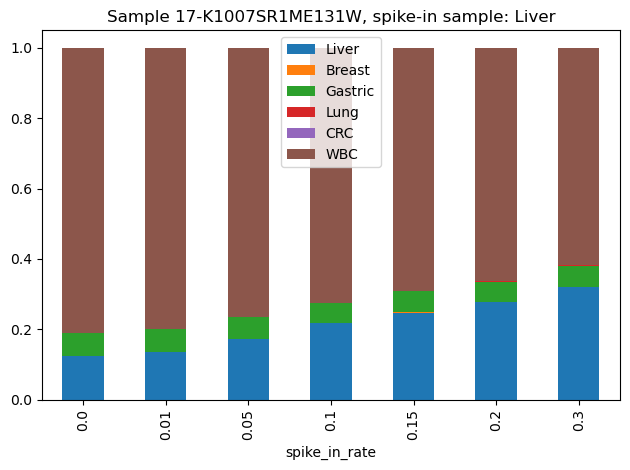

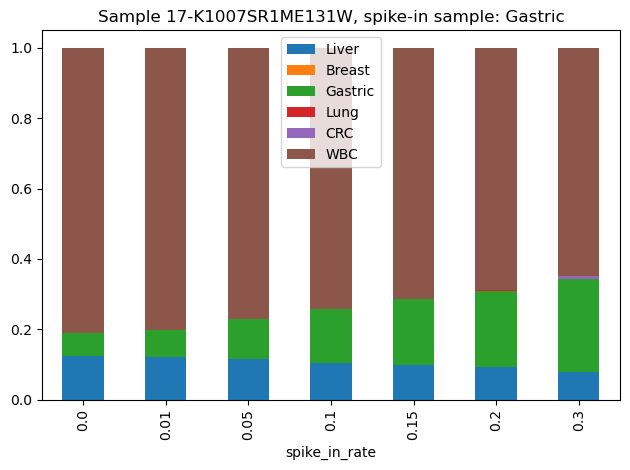

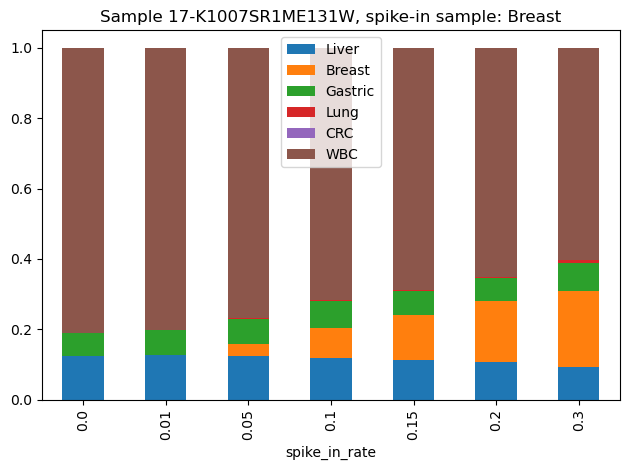

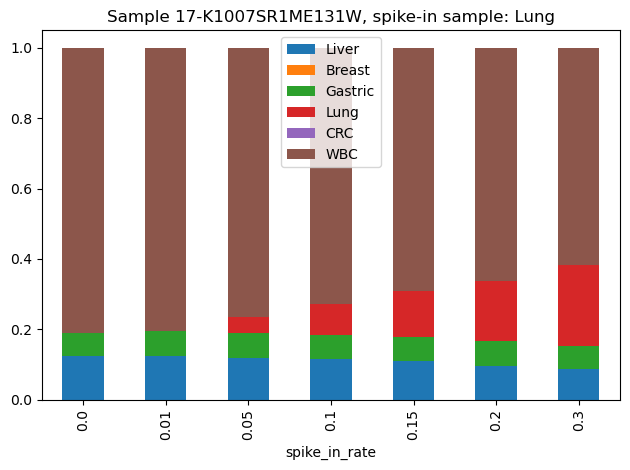

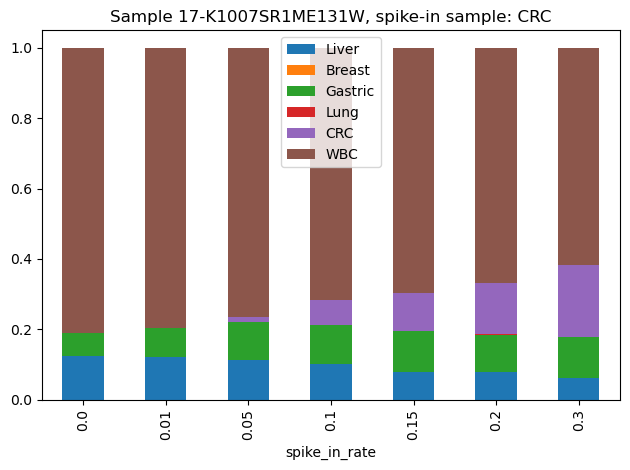

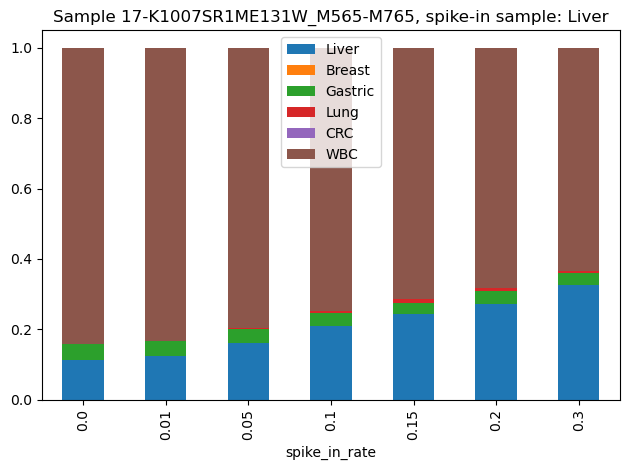

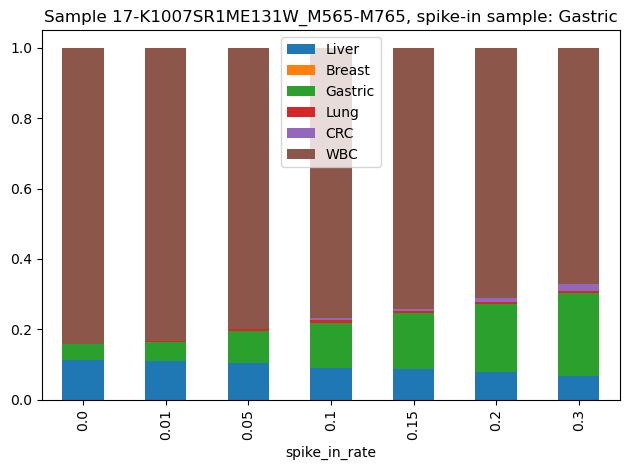

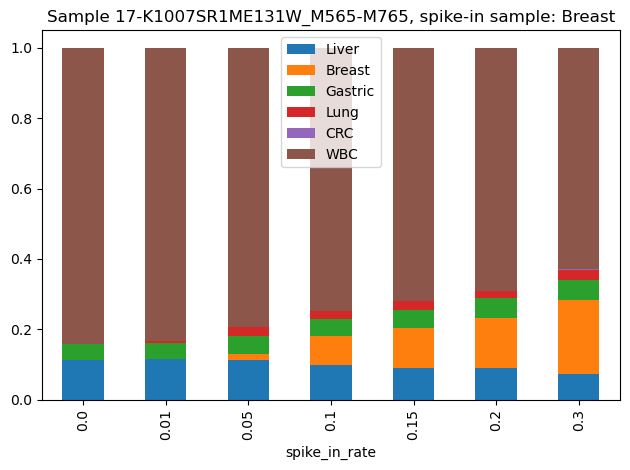

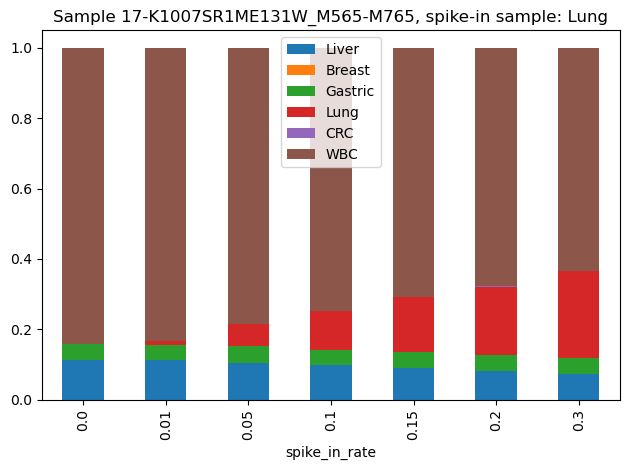

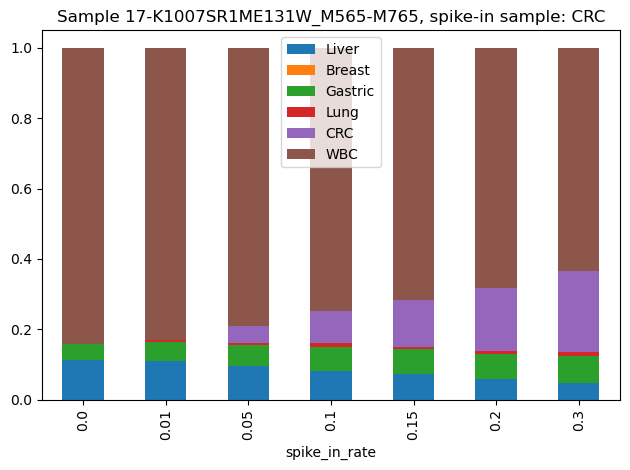

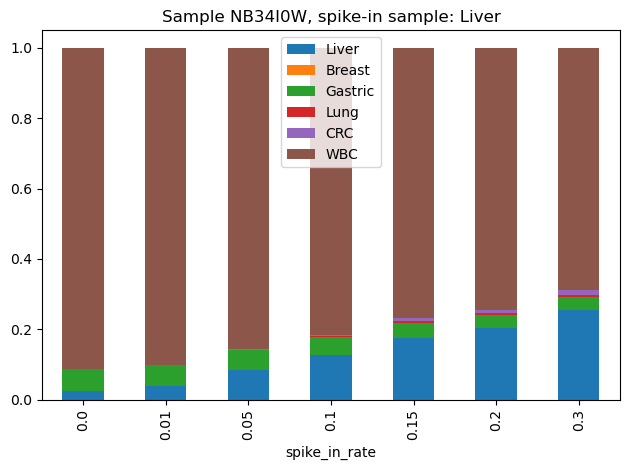

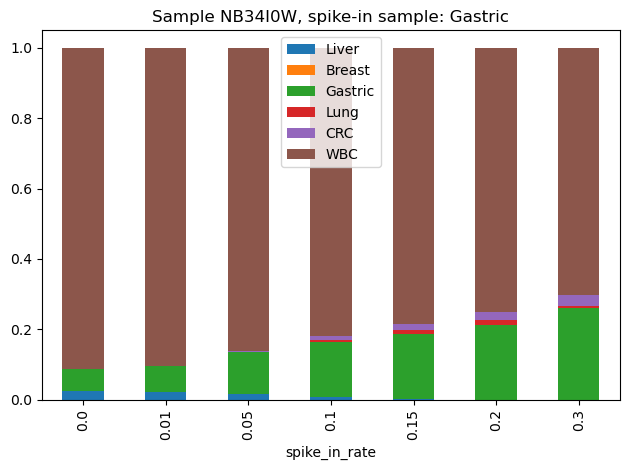

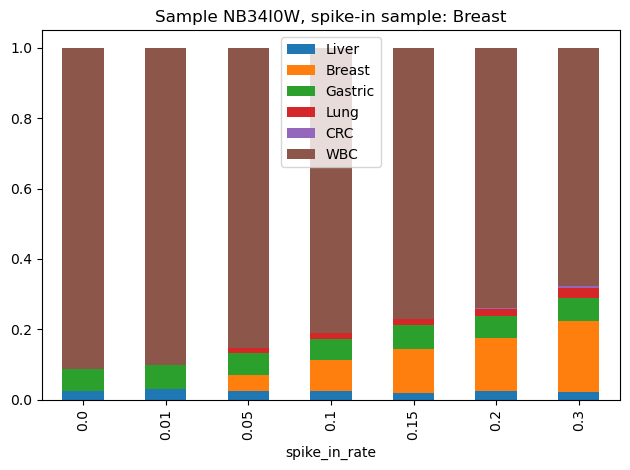

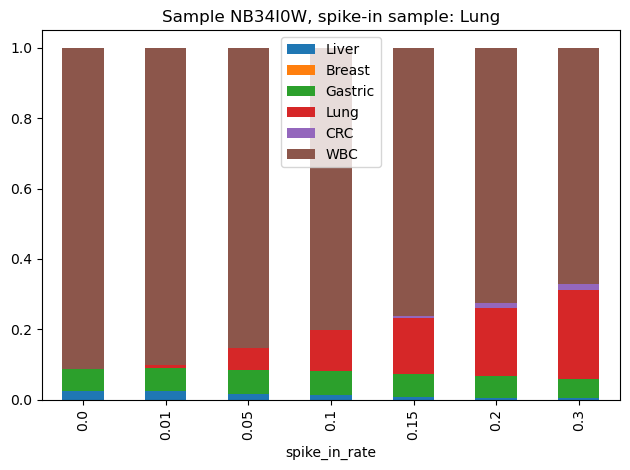

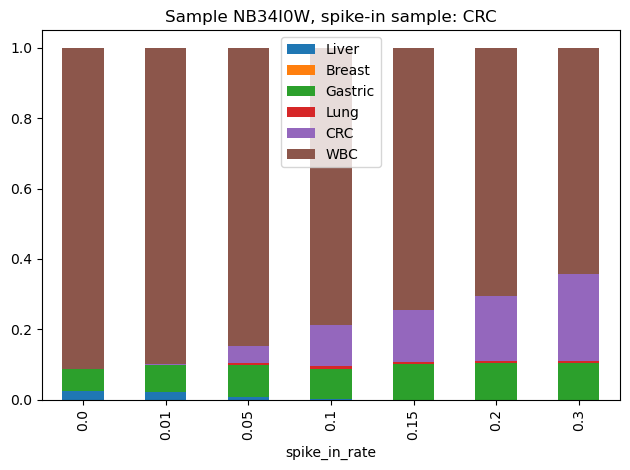

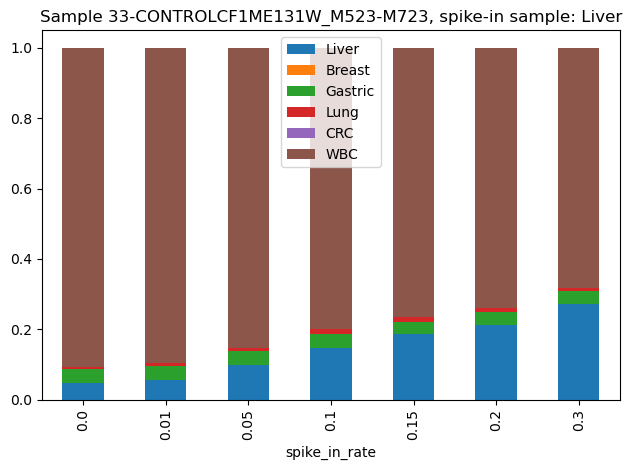

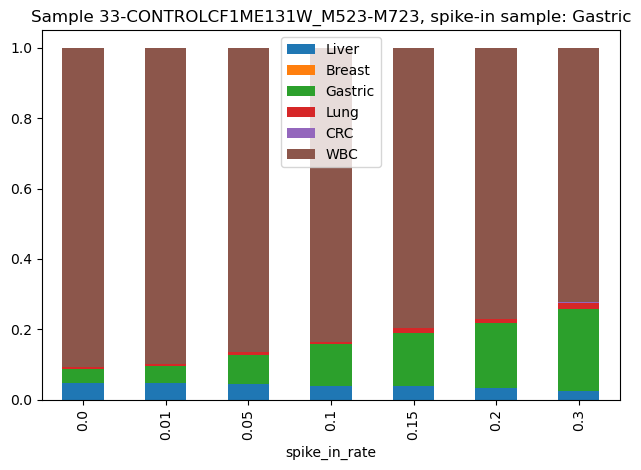

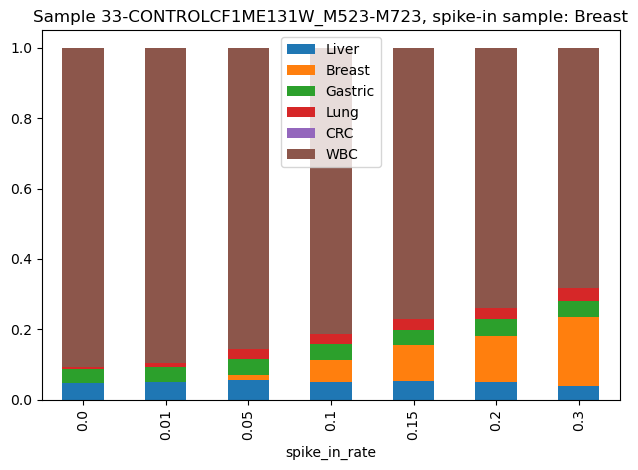

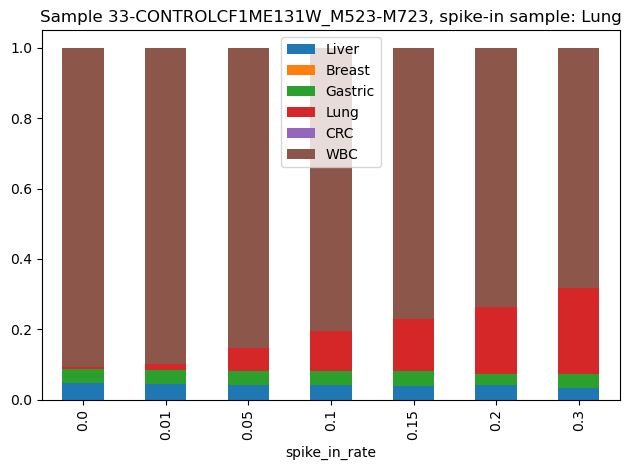

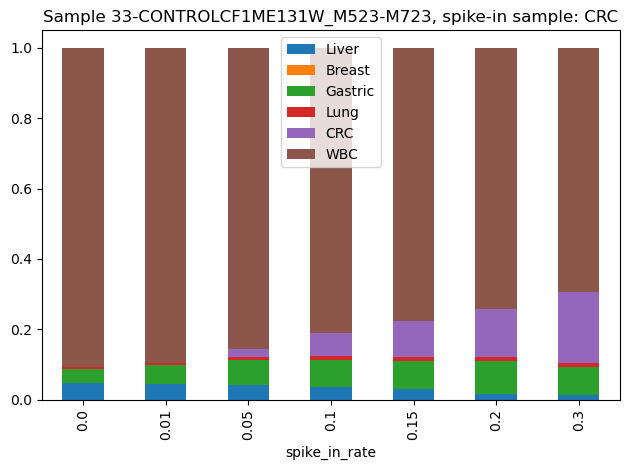

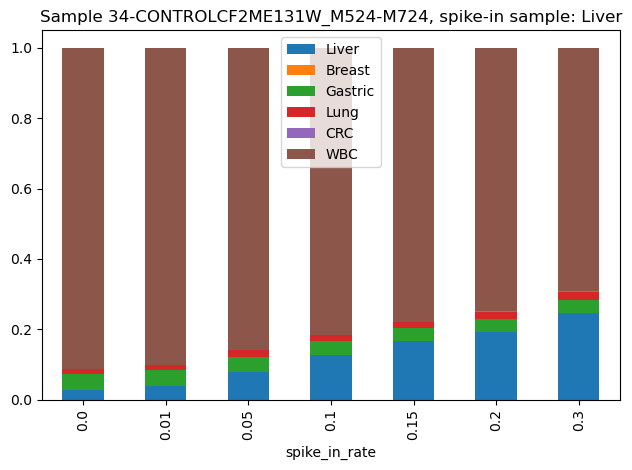

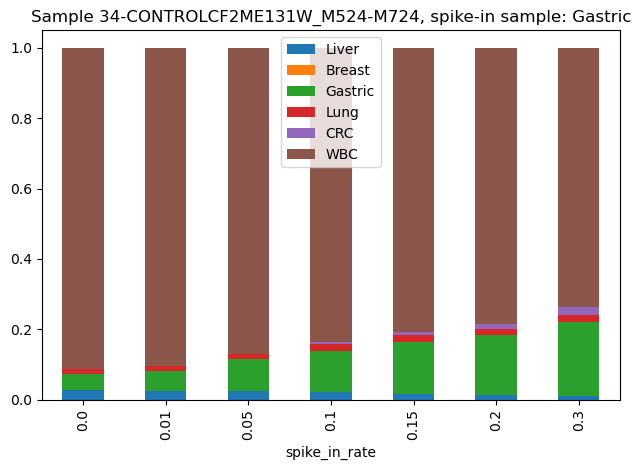

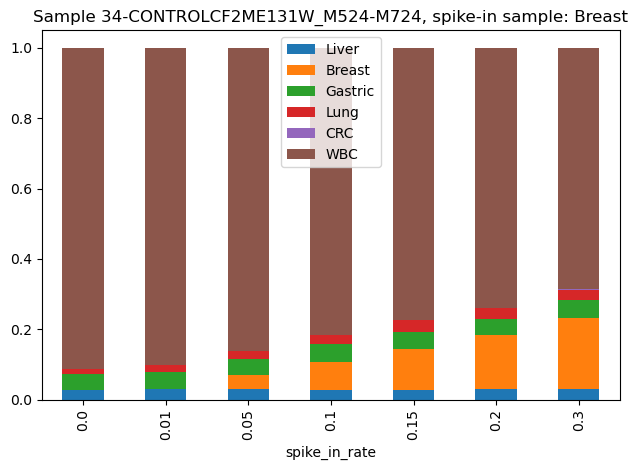

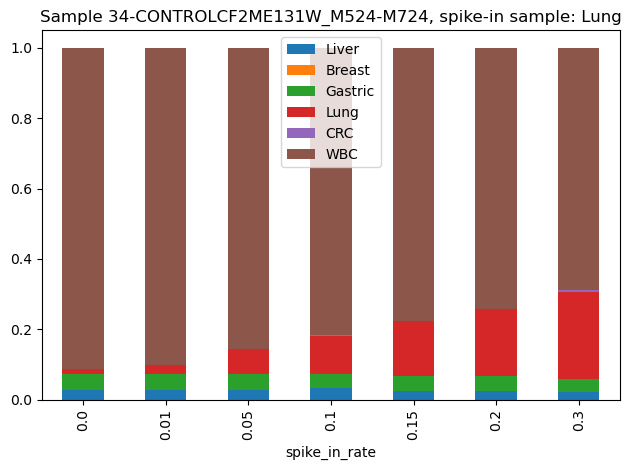

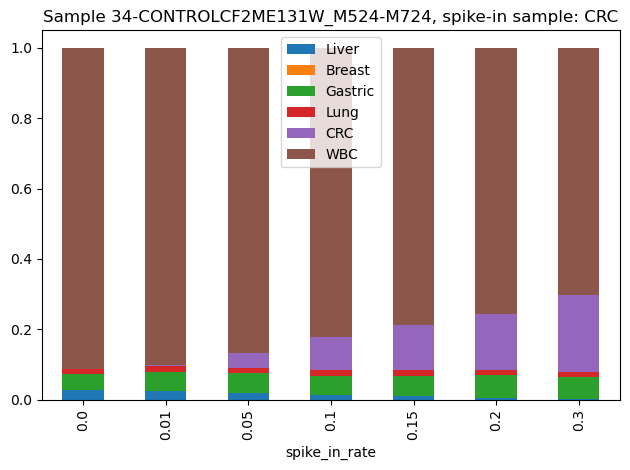

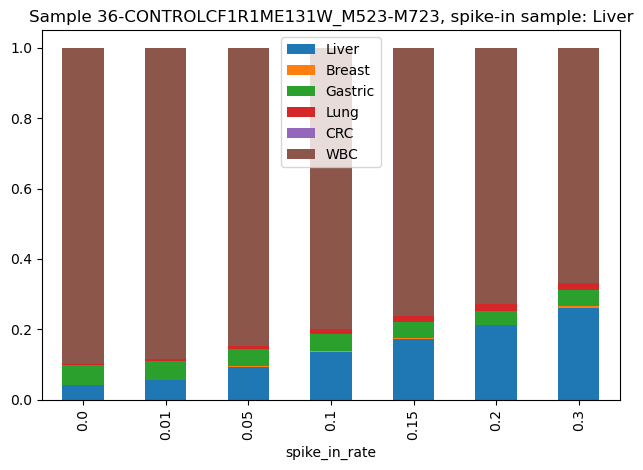

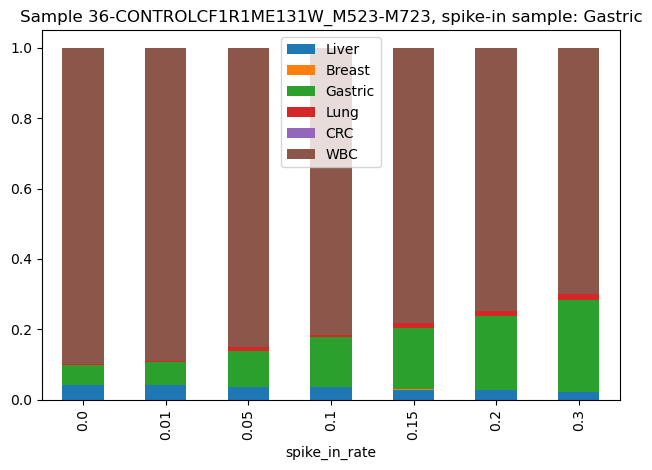

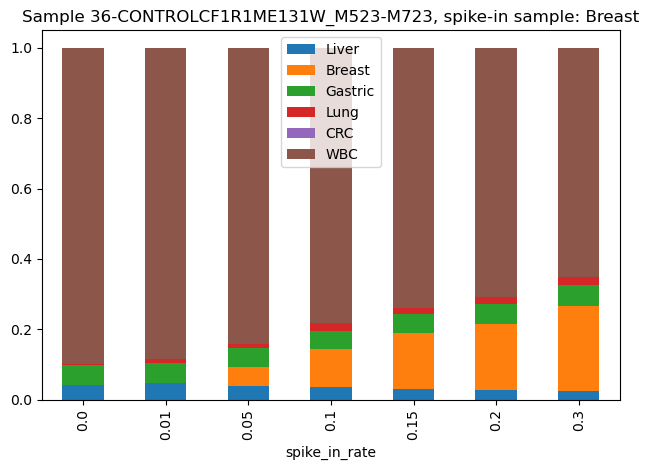

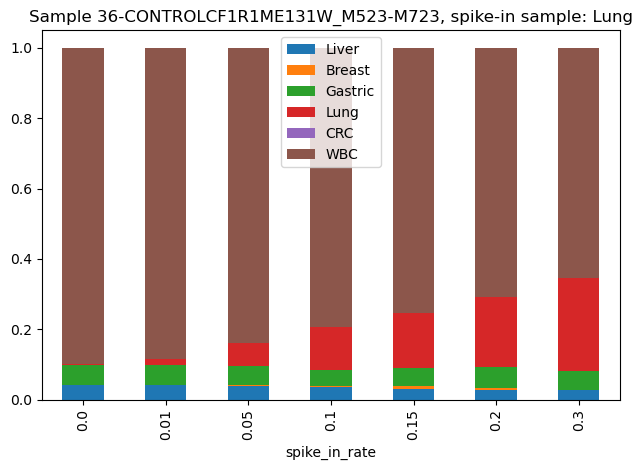

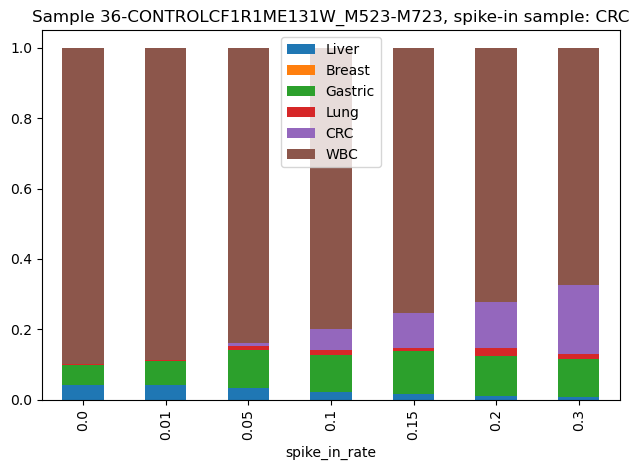

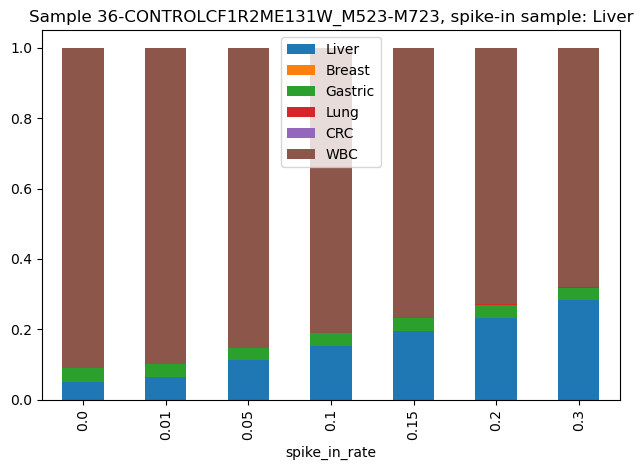

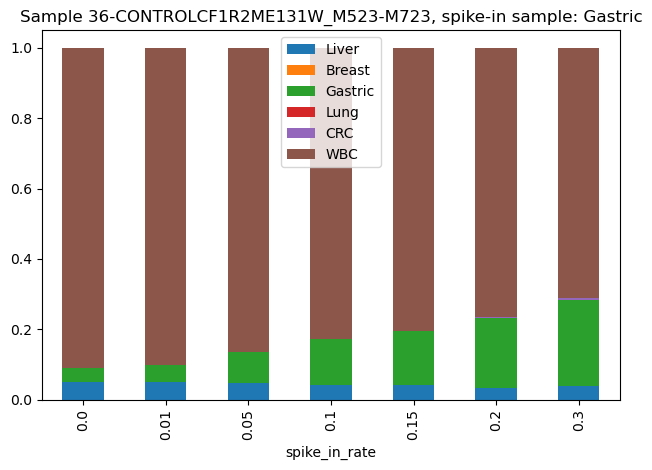

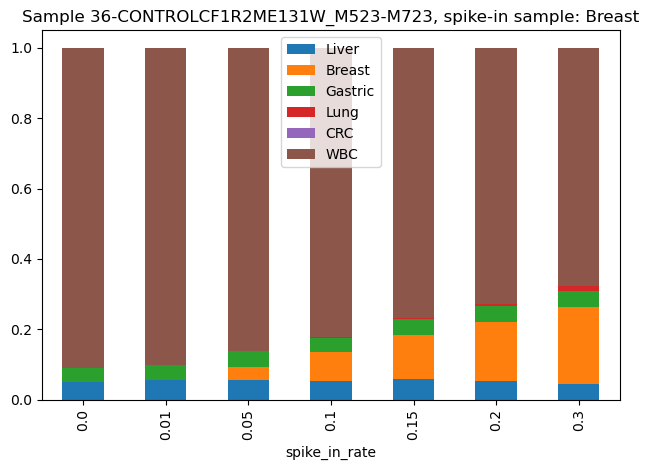

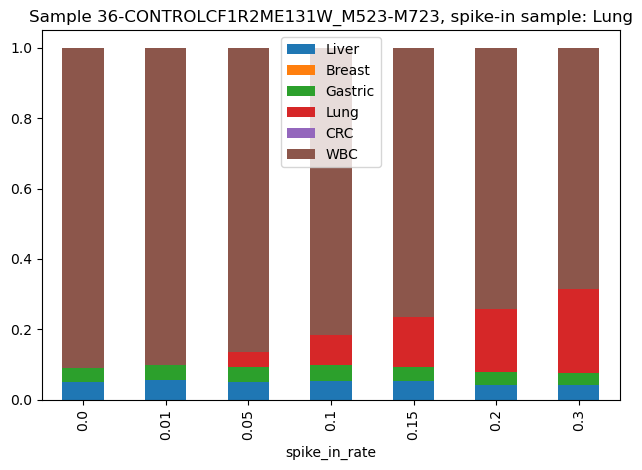

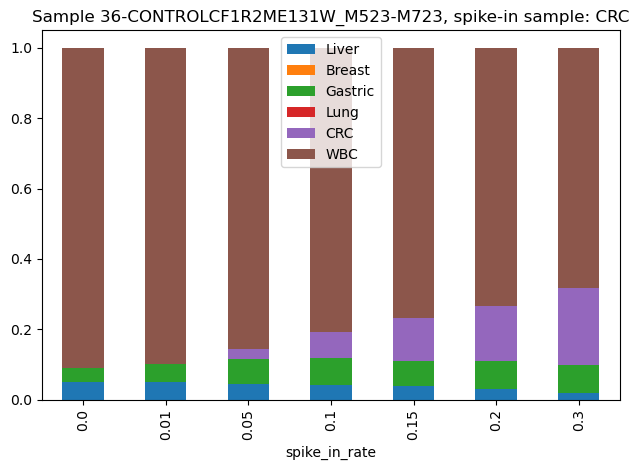

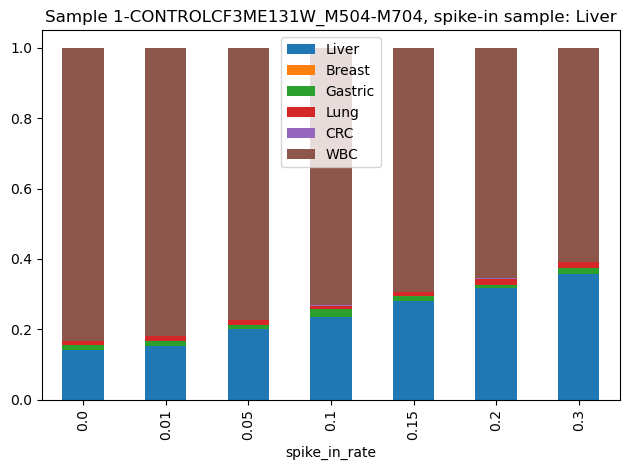

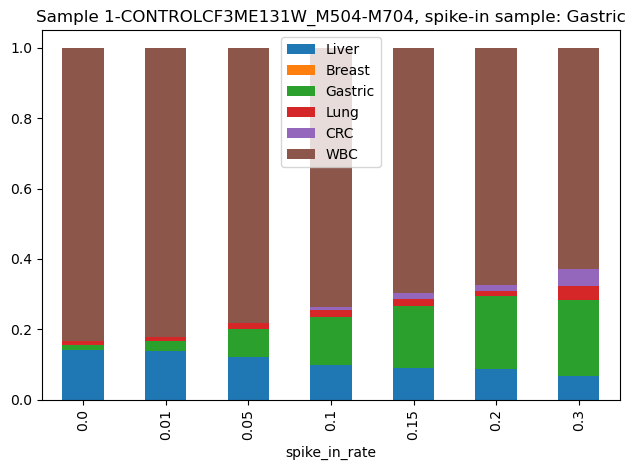

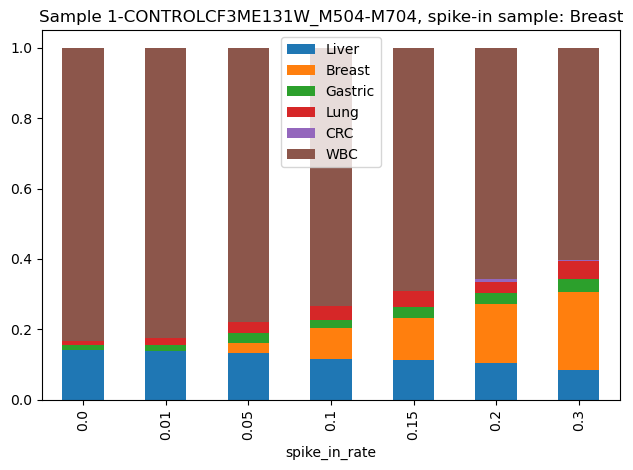

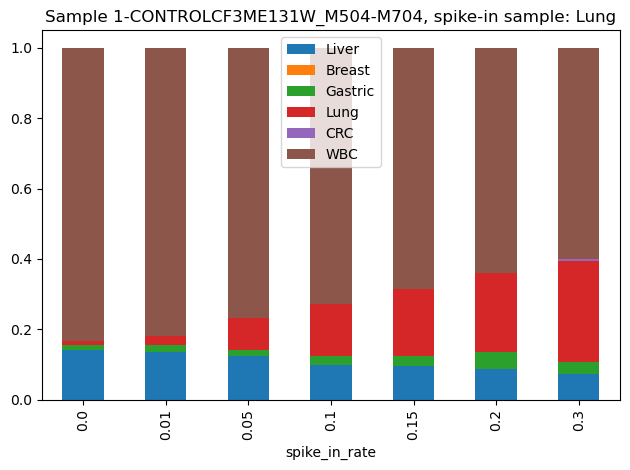

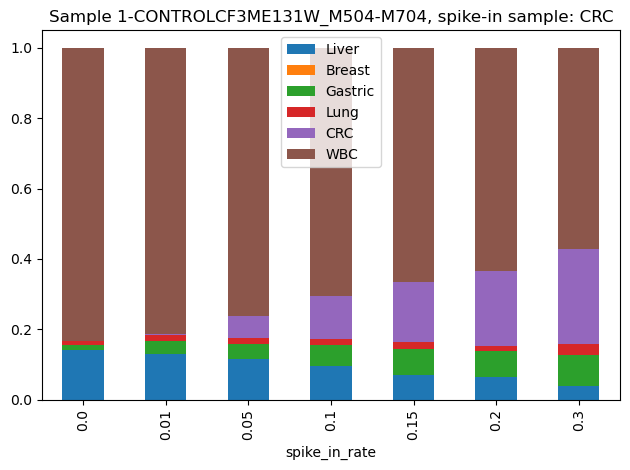

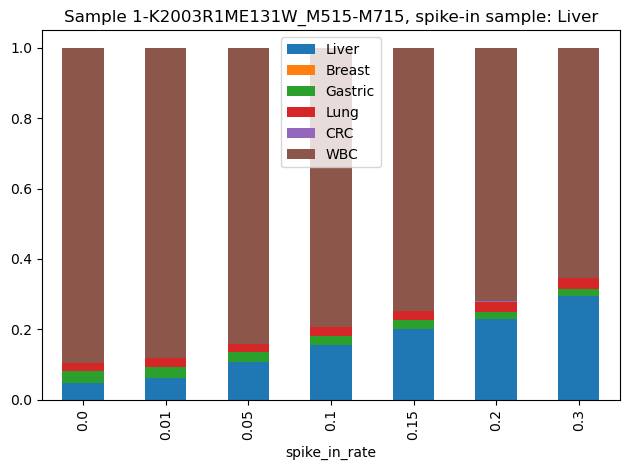

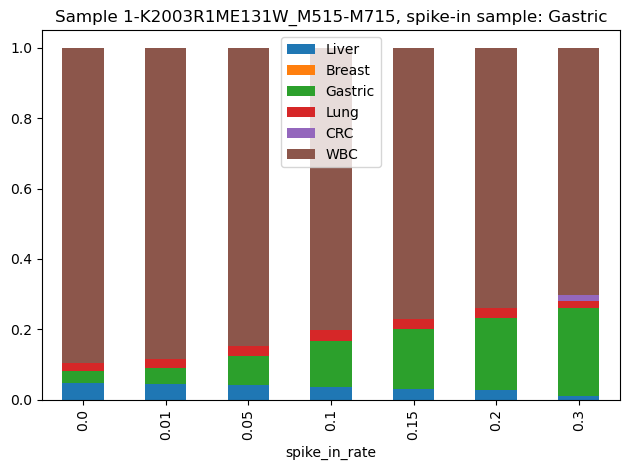

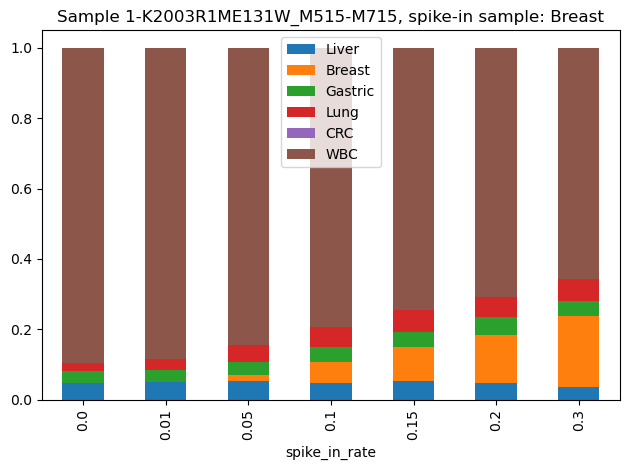

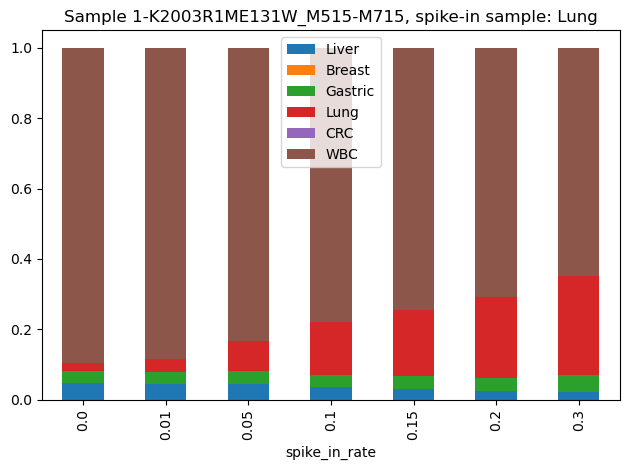

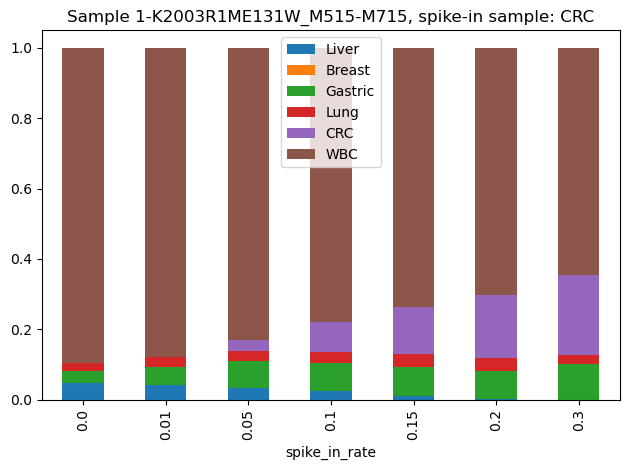

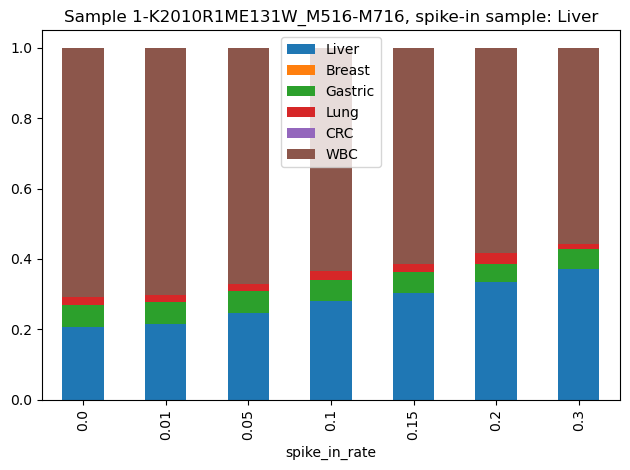

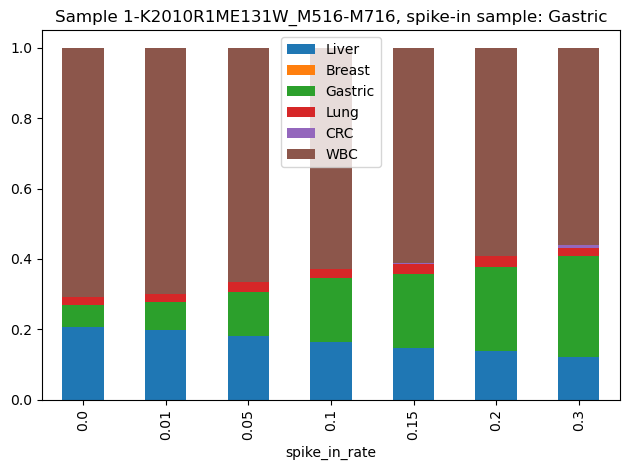

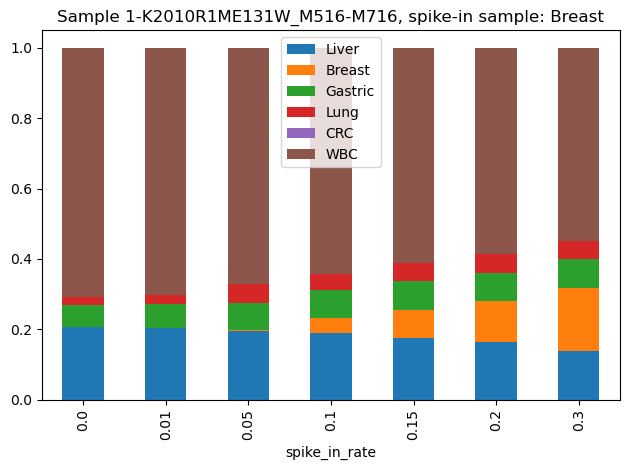

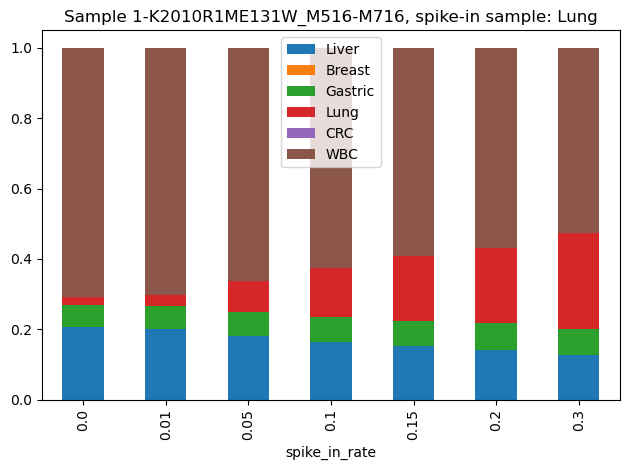

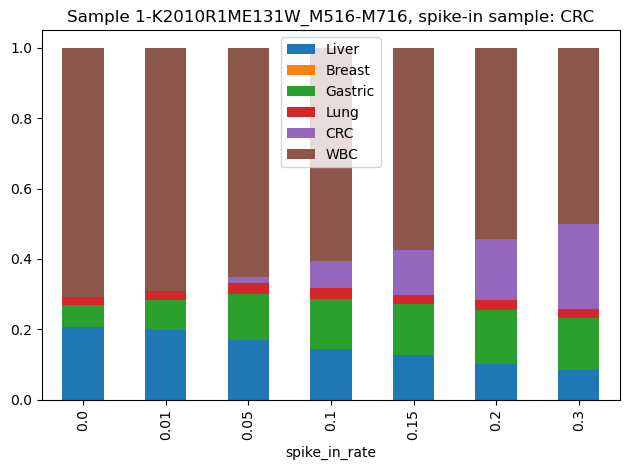

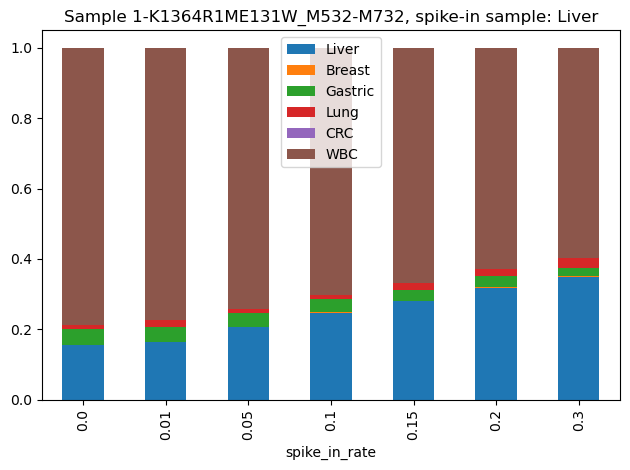

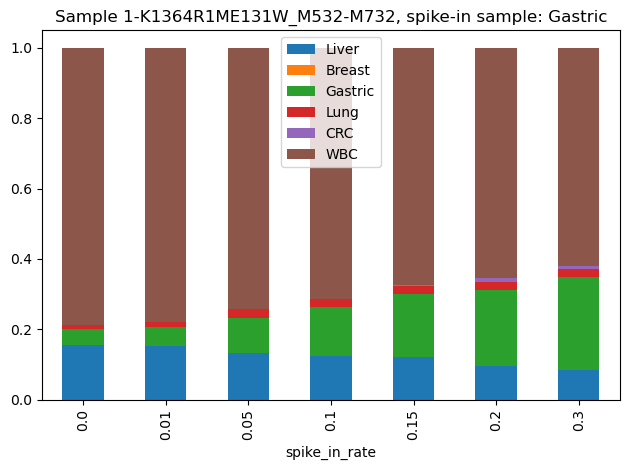

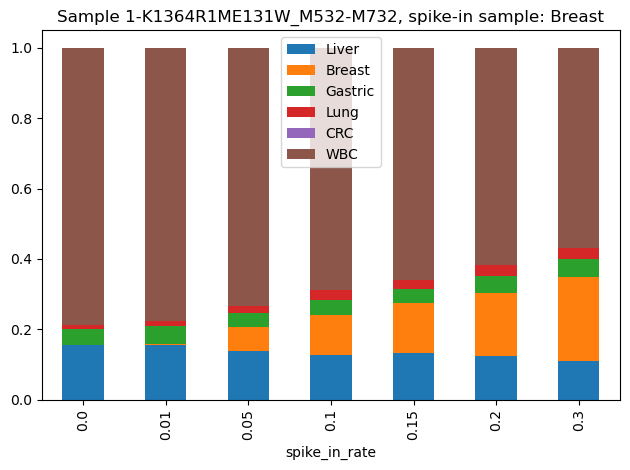

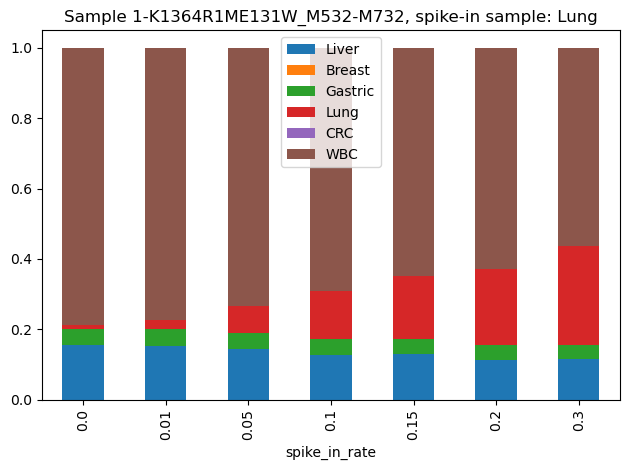

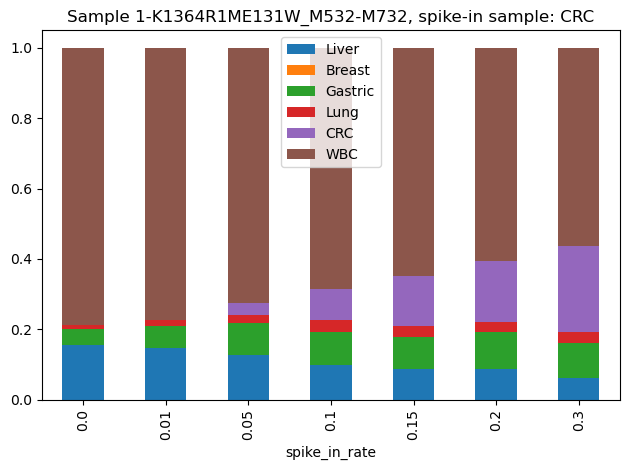

In [9]:
deconvo_res_control = deconvo(dfcontrol, avg_atlas, atlas_sample_types)
deconvo_res_control = deconvo_res_control.set_index("TOO").T
deconvo_res_control = deconvo_res_control.reset_index(0)
deconvo_res_control.columns = ["Sample" if item == "index" else item for item in deconvo_res_control.columns]
deconvo_res_control["spike_in_rate"] = 0

# sampleid = "17-K1007SR1ME131W"
# spike_in_type = "Liver"

for sampleid in resdf["Sample"].unique():
    os.system("mkdir -p {}".format(os.path.join(path_to_00_output, sampleid)))
    for spike_in_type in resdf["spike_in_sample"].unique():
        spikeindf = resdf[resdf["spike_in_sample"] == spike_in_type]
        spikeindf = spikeindf.groupby(["Sample", "spike_in_rate"])[atlas_labels[atlas_sample_types]].mean().reset_index()
        
        sampledf = spikeindf[spikeindf["Sample"] == sampleid]
        
        sample_deconvo_res_control = deconvo_res_control[deconvo_res_control["Sample"] == sampleid]
        sample_deconvo_res_control = sample_deconvo_res_control[sampledf.columns]
        sampledf = pd.concat([sample_deconvo_res_control, sampledf ], axis = 0)
        plot = sampledf.drop(["Sample"], axis = 1).set_index("spike_in_rate").plot(kind = "bar", stacked = True, title = "Sample {}, spike-in sample: {}".format(sampleid, spike_in_type))
        # plt.title("Sample {}, spike-in sample: {}".format(sampleid, spike_in_type))
        plt.tight_layout()
        plot.get_figure().savefig(os.path.join(path_to_00_output, sampleid, "Sample_{}_spike_in_sample_{}.png".format(sampleid, spike_in_type)))

In [10]:
deconvo_res_control

,Sample,Liver,Breast,Gastric,Lung,CRC,WBC,spike_in_rate
0,17-K1007SR1ME131W,0.123154,0.0,0.066207,0.000000,0.0,0.810639,0
1,17-K1007SR1ME131W_M565-M765,0.113899,0.0,0.043471,0.000479,0.0,0.842152,0
2,NB34I0W,0.024676,0.0,0.061804,0.000000,0.0,0.913520,0
3,33-CONTROLCF1ME131W_M523-M723,0.046856,0.0,0.040241,0.005643,0.0,0.907259,0
4,34-CONTROLCF2ME131W_M524-M724,0.025938,0.0,0.046640,0.013818,0.0,0.913604,0
5,36-CONTROLCF1R1ME131W_M523-M723,0.042616,0.0,0.056984,0.002622,0.0,0.897778,0
6,36-CONTROLCF1R2ME131W_M523-M723,0.051052,0.0,0.038390,0.000000,0.0,0.910558,0
7,1-CONTROLCF3ME131W_M504-M704,0.139883,0.0,0.015549,0.011638,0.0,0.832930,0
8,1-K2003R1ME131W_M515-M715,0.047284,0.0,0.032755,0.024839,0.0,0.895123,0
9,1-K2010R1ME131W_M516-M716,0.205115,0.0,0.063790,0.022052,0.0,0.709042,0


In [11]:
deconvo_res_cfdna["Label"] = deconvo_res_cfdna["Sample"].apply(lambda x: metadata[metadata["filename"] == x]["Label"].unique()[0])

In [12]:
tissue_labels = [item for item in atlas_labels[atlas_sample_types] if item != "WBC"]
deconvo_res_cfdna["prediction"] = deconvo_res_cfdna[tissue_labels].apply(
    lambda x: tissue_labels[list(x).index(max(x))], axis = 1)

In [13]:
deconvo_res_cfdna["check"] = deconvo_res_cfdna[["Label", "prediction"]].apply(
    lambda x: "yes" if x[0] == x[1] else "no", axis = 1
)

In [14]:
deconvo_res_cfdna.groupby(["check", "Label"])["Sample"].count()

check  Label  
no     Breast     16
       CRC         7
       Gastric     3
       Lung        8
yes    Breast      2
       Gastric     3
       Liver       7
       Lung        2
Name: Sample, dtype: int64

In [15]:
deconvo_res_cfdna[(deconvo_res_cfdna["check"] == "yes") & (deconvo_res_cfdna["Label"] == "Lung")]

,Sample,Liver,Breast,Gastric,Lung,CRC,WBC,Label,prediction,check
39,1-L12309R2ME131W_M502-M702,0.050556,0.000000,0.059782,0.074320,0.0,0.815342,Lung,Lung,yes
40,1-L12008R1ME131W_M505-M705,0.018560,0.037806,0.048796,0.080916,0.0,0.813921,Lung,Lung,yes


In [16]:
depthdf = pd.read_csv("./cfDNA_highdepth.csv")

In [17]:
deconvo_res_cfdna["depth"] = deconvo_res_cfdna["Sample"].apply(
    lambda x: depthdf[depthdf["SampleID"] == x]["Depth"].unique()[0]
)

<Axes: title={'center': 'depth'}, xlabel='Label'>

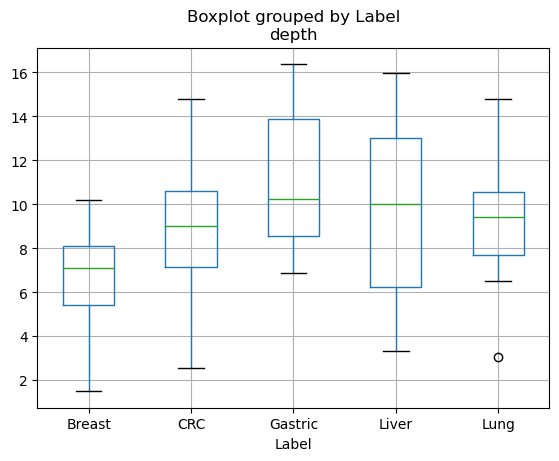

In [18]:
deconvo_res_cfdna.boxplot(by = "Label",column="depth")

In [19]:
pd.concat([deconvo_res_cfdna, deconvo_res_control], axis = 0).to_csv(os.path.join(outputdir, "Loyfer_UXM_deconvolution", "deconvo_by_{}_{}.csv".format(
    topK, atlas_sample_types
)))